In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Data preprocessing
The missing attribute is represented using '?'. Thus, we need to replace the '?' by nan value then drop the rows contain nan.

In [2]:
df = pd.read_csv('breast-cancer-wisconsin.data.csv', header=None)
df.replace('?',np.nan, inplace=True)
df = df.dropna()

X_df = df.iloc[:,0:-1]
y_df = df.iloc[:,-1].map({2:0, 4:1})

X = X_df.to_numpy()
X = StandardScaler().fit_transform(X)
y = y_df.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/Users/stn/PycharmProjects/u2os/YoloNuclei/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/stn/PycharmProjects/u2os/YoloNuclei/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [3]:
print('Number of Benign class: {}. \nNumber of Malignant class: {}.'.format(y_df[y_df==0].count(), y_df[y_df==1].count()))

Number of Benign class: 444. 
Number of Malignant class: 239.


## Statistical analysis
We calculate the pearson correlation coefficient between each features and class index.

In [4]:
df.corr(method='pearson')

,0,1,2,3,4,5,7,8,9,10
0,1.000000,-0.056350,-0.041396,-0.042221,-0.069630,-0.048644,-0.061966,-0.050699,-0.037972,-0.084701
1,-0.056350,1.000000,0.642481,0.653470,0.487829,0.523596,0.553742,0.534066,0.350957,0.714790
2,-0.041396,0.642481,1.000000,0.907228,0.706977,0.753544,0.755559,0.719346,0.460755,0.820801
3,-0.042221,0.653470,0.907228,1.000000,0.685948,0.722462,0.735344,0.717963,0.441258,0.821891
4,-0.069630,0.487829,0.706977,0.685948,1.000000,0.594548,0.668567,0.603121,0.418898,0.706294
5,-0.048644,0.523596,0.753544,0.722462,0.594548,1.000000,0.618128,0.628926,0.480583,0.690958
7,-0.061966,0.553742,0.755559,0.735344,0.668567,0.618128,1.000000,0.665602,0.346011,0.758228
8,-0.050699,0.534066,0.719346,0.717963,0.603121,0.628926,0.665602,1.000000,0.433757,0.718677
9,-0.037972,0.350957,0.460755,0.441258,0.418898,0.480583,0.346011,0.433757,1.000000,0.423448
10,-0.084701,0.714790,0.820801,0.821891,0.706294,0.690958,0.758228,0.718677,0.423448,1.000000


We can find that almost all the features show strong linear correlation with the class index.

## Data visualizations
## PCA

In [5]:
from sklearn.decomposition import PCA

In [6]:
pca_model = PCA(n_components=2)
pca_components = pca_model.fit_transform(X)
pca_df = pd.DataFrame(data=pca_components, columns=['component_1', 'component_2'])
target_df = pd.DataFrame(data=y, columns=['target'])
pca_df = pd.concat([pca_df,target_df], axis=1)
pca_df.head()

,component_1,component_2,target
0,-1.465037,-0.180405,0
1,1.445675,-0.187361,0
2,-1.588076,-0.171585,0
3,1.481801,0.067605,0
4,-1.340695,-0.164636,0


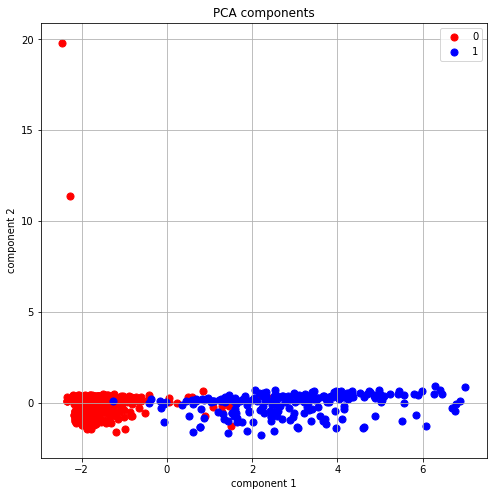

In [7]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.set_title('PCA components')
targets = [0,1]
colors = ['r','b']
for target, color in zip(targets, colors):
    indices = pca_df['target']==target
    ax.scatter(pca_df.loc[indices,'component_1'], pca_df.loc[indices,'component_2'],c=color, s=50)
ax.legend(targets)
ax.grid()    

## t-SNE

In [8]:
from sklearn.manifold import TSNE

In [9]:
tsne_model = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_components = tsne_model.fit_transform(X)
tsne_df = pd.DataFrame(data=tsne_components, columns=['tsne_1', 'tsne_2'])
tsne_df = pd.concat([tsne_df, target_df], axis=1)
tsne_df.head()

,tsne_1,tsne_2,target
0,1.755599,-3.375269,0
1,9.446494,20.487942,0
2,-5.859907,-6.315956,0
3,19.001707,14.288898,0
4,-1.376088,-0.147478,0


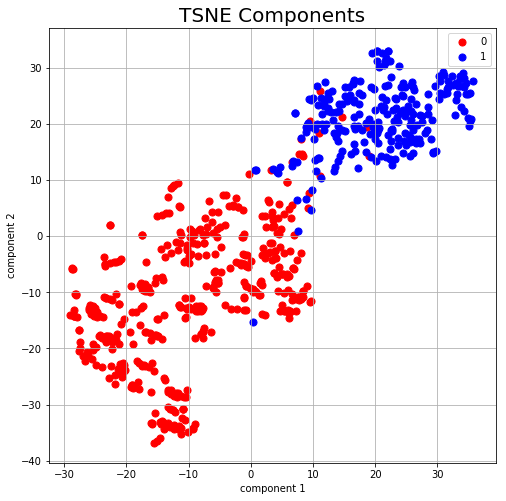

In [10]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.set_title('TSNE Components', fontsize=20)
colors = ['r','b']
targets = [0,1]
for target, color in zip(targets, colors):
    indices = tsne_df['target']==target
    ax.scatter(tsne_df.loc[indices, 'tsne_1'], tsne_df.loc[indices, 'tsne_2'], c=color, s=50)
ax.legend(targets)
ax.grid()

## XGBoost for feature selection and classification

In [11]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [12]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, use_label_encoder=False, eval_metric=['auc'])
xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.97436
[1]	validation_0-auc:0.99225
[2]	validation_0-auc:0.99138
[3]	validation_0-auc:0.99127
[4]	validation_0-auc:0.99149
[5]	validation_0-auc:0.99323
[6]	validation_0-auc:0.99302
[7]	validation_0-auc:0.99258
[8]	validation_0-auc:0.99323
[9]	validation_0-auc:0.99323
[10]	validation_0-auc:0.99389
[11]	validation_0-auc:0.99433
[12]	validation_0-auc:0.99542
[13]	validation_0-auc:0.99498
[14]	validation_0-auc:0.99564
[15]	validation_0-auc:0.99585
[16]	validation_0-auc:0.99520
[17]	validation_0-auc:0.99564
[18]	validation_0-auc:0.99564
[19]	validation_0-auc:0.99585
[20]	validation_0-auc:0.99629
[21]	validation_0-auc:0.99651
[22]	validation_0-auc:0.99629
[23]	validation_0-auc:0.99629
[24]	validation_0-auc:0.99673
[25]	validation_0-auc:0.99673
[26]	validation_0-auc:0.99651
[27]	validation_0-auc:0.99651
[28]	validation_0-auc:0.99651


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric=['auc'],
       gamma=0, gpu_id=-1, importance_type='gain',
       interaction_constraints='', learning_rate=0.300000012,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
       monotone_constraints='()', n_estimators=100, n_jobs=8,
       num_parallel_tree=1, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
       tree_method='exact', use_label_encoder=False, validate_parameters=1,
       verbosity=None)

In [13]:
print('best AUC score achieved at iteration {} with ntree {}'.format(xgb_model.best_iteration,xgb_model.best_ntree_limit))
xgb_pred = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)
print('XGBoost model achieves auc score: {:.3f}, acc score: {:.3f}'.format(xgb_model.best_score, xgb_acc))
print('Feature importance: {}'.format(xgb_model.feature_importances_))

best AUC score achieved at iteration 24 with ntree 25
XGBoost model achieves auc score: 0.997, acc score: 0.964
Feature importance: [0.01145728 0.02305023 0.5423195  0.29322496 0.01149088 0.01835848
 0.04905907 0.02536974 0.02566999 0.        ]


## Neural Network

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout

In [22]:
def create_nn_model(features_nums):
    input = Input(shape=(features_nums), name='input_layer')
    x = Dense(16, activation='relu', name='h1')(input)
    x = Dense(16, activation='relu', name='h2')(x)
    x = Dense(8, activation='relu', name='h3')(x)
    output = Dense(1, activation='sigmoid', name='output_layer')(x)
    
    return Model(inputs=input, outputs=output)

In [23]:
nn_model=create_nn_model(X_train.shape[1])
nn_model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy', tf.metrics.AUC()])
nn_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 10)]              0         
_________________________________________________________________
h1 (Dense)                   (None, 16)                176       
_________________________________________________________________
h2 (Dense)                   (None, 16)                272       
_________________________________________________________________
h3 (Dense)                   (None, 8)                 136       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 9         
Total params: 593
Trainable params: 593
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = nn_model.fit(X_train, y_train, epochs=11, batch_size=10, validation_split=0.2, verbose=0)

In [25]:
res_nn = nn_model.evaluate(X_test, y_test)
print('The neural network model achieves acc of {:.3f}, and auc of {:.3f}.'.format(res_nn[1],res_nn[2]))

5/5 [==============================] - 0s 2ms/step - loss: 0.0615 - accuracy: 0.9781 - auc_1: 0.9978
The neural network model achieves acc of 0.978, and auc of 0.998.


In [26]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'auc_1', 'val_loss', 'val_accuracy', 'val_auc_1'])


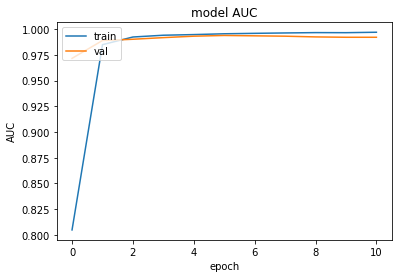

In [27]:
# summarize history for accuracy
plt.plot(history.history['auc_1'])
plt.plot(history.history['val_auc_1'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

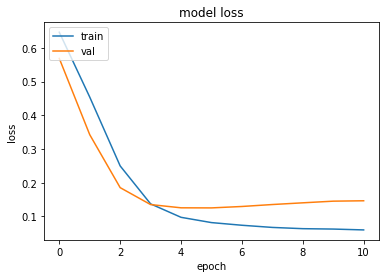

In [28]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Classification
The neural network model and the XGBoost model have similar performance in terms of the auc and accuracy scores. Both accuracy scores indicates better performance than the original studys $^{[1, 2]}$.

In [30]:
print('XGBoost model achieves acc score: {:.3f}, auc score: {:.3f}'.format(xgb_acc, xgb_model.best_score))
print('The neural network model achieves acc of {:.3f}, and auc of {:.3f}.'.format(res_nn[1],res_nn[2]))

XGBoost model achieves acc score: 0.964, auc score: 0.997
The neural network model achieves acc of 0.978, and auc of 0.998.


# References
   1. Wolberg,~W.~H., \& Mangasarian,~O.~L. (1990). Multisurface method of 
      pattern separation for medical diagnosis applied to breast cytology. In
      {\it Proceedings of the National Academy of Sciences}, {\it 87},
      9193--9196.
   2. Zhang,~J. (1992). Selecting typical instances in instance-based
      learning.  In {\it Proceedings of the Ninth International Machine
      Learning Conference} (pp. 470--479).

## Data Source
Website: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Dataset source: https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data

Dataset deails: https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.names